# Image pipeline
* Written for the Manning Live Project - [\"Semi supervised deep learning with gans for melanoma detection\"](https://liveproject.manning.com/project/146/29/semi-supervised-deep-learning-with-gans-for-melanoma-detection)
* Consists of data loaders for labelled and unlabelled data

## Imports

In [1]:
import os
from torchvision import io
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from operator import itemgetter
import torch
import numpy as np
import re

## Code paths

In [2]:
dataset_path = "Datasets/MelanomaDetection/"
unlabelled_dataset_path = dataset_path + "unlabeled"
labelled_dataset_path = dataset_path + "labeled"

## Helpers

In [3]:
def arrayToDictionary(array):
    return {k: v for k, v in enumerate(array)}


def extract_label(s):
    if re.findall(".*_1.jpg", s):
        return True
    elif re.findall(".*_0.jpg", s):
        return False
    else:
        raise RuntimeError("Invalid filename format: " + s)

## Dataset

* I don't like inheritance. So have provided one class that accepts a pluggable extractor for determining labels. I think this is a neater solution than creating an abstract base class to share functionality or duplicating code

In [4]:
class MelanomaDataset(Dataset):
    """Unlabelled Melanoma datasets"""

    def __init__(self, label_extractor, dir_path, transform=None):
        self.label_extractor = label_extractor
        self.dir_path = dir_path
        self.transform = transform
        file_list = filter(lambda e: e != ".DS_Store", os.listdir(dir_path))
        self.file_list = arrayToDictionary(file_list)
        self.len = len(self.file_list)

    def __len__(self):
        return self.len

    def __getitem__(self, index):
        if index >= self.len:
            raise IndexError
        else:
            img_name = self.file_list[index]
            full_img_name = os.path.join(self.dir_path, img_name)
            image = io.read_image(full_img_name)

            result = {'name': img_name,
                      'image': image}

            if self.label_extractor:
                result['label'] = self.label_extractor(img_name)

            if self.transform:
                result = self.transform(result)

            return result

## Utility function to show data and labels

* To help test the loader, this function displays a batch and the labels

In [5]:
def show_batch(data_loader):
    data_iter = iter(data_loader)
    data = data_iter.next()
    names, images = itemgetter('name', 'image')(data)
    labels = data['label'] if 'label' in data else None

    fig = plt.figure()
    for index, (name, image) in enumerate(zip(names, images)):
        a = fig.add_subplot(4, 8, index + 1)

        # Title each image with filename (so we can check it)
        # And label if it exists
        title = name
        if labels is not None:
            label_value = labels[index].item()
            v = "Positive" if label_value else "Negative"
            title += "\n" + v
        a.set_title(title)

        a.axis('off')
        adj_image = torch.swapaxes(torch.swapaxes(image, 0, 1), 1, 2)
        plt.imshow(adj_image)

    fig.set_size_inches(np.array(fig.get_size_inches()) * 2)
    plt.show()

## Unlabelled dataset

* Loads unlabelled data and displays one batch

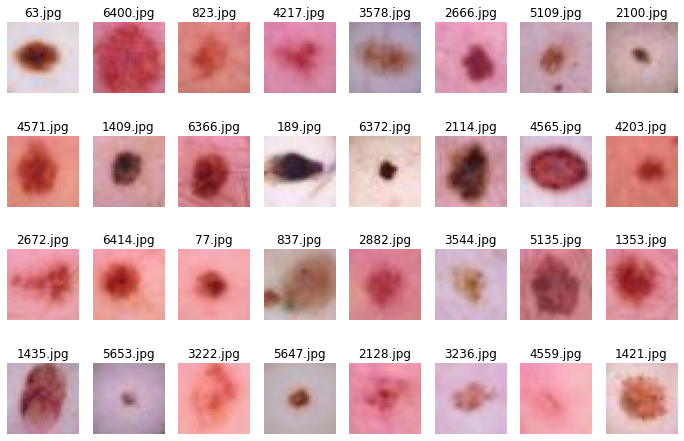

In [6]:
    unlabelled = MelanomaDataset(None, unlabelled_dataset_path)
    unlabelled_loader = DataLoader(unlabelled, batch_size=32, shuffle=False)
    show_batch(unlabelled_loader)

## Labelled dataset

* Loads labelled data and displays one batch

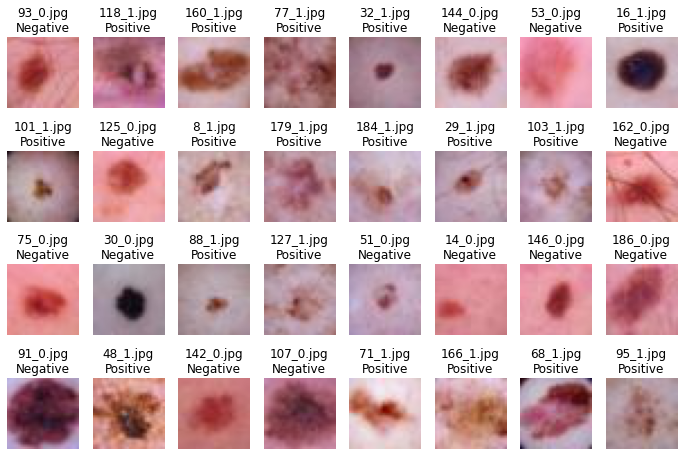

In [7]:
    labelled = MelanomaDataset(extract_label, labelled_dataset_path)
    labelled_loader = DataLoader(labelled, batch_size=32, shuffle=False)
    show_batch(labelled_loader)